In [ ]:
!pip install quandl

In [ ]:
from datetime import datetime
import pandas as pd
from fbprophet import Prophet
import seaborn as sns
import quandl
import matplotlib.pyplot as plt

In [ ]:
!pip install fbprophet

In [ ]:
QUANDL_KEY='key'
quandl.ApiConfig.api_key = QUANDL_KEY

df=quandl.get(dataset='WGC/GOLD_DAILY_USD',start_date='2000-01-01',end_date='2005-12-31')
df.reset_index(drop=False,inplace=True)
df.rename(columns={'Date':'ds','Value':'y'},inplace=True)
df.head()

,ds,y
0,2000-01-03,290.25
1,2000-01-04,281.50
2,2000-01-05,280.45
3,2000-01-06,279.40
4,2000-01-07,282.10


In [ ]:
train_indices=df.ds.apply(lambda x: x.year)<2005
df_train=df[train_indices].dropna()
df_test=df.loc[~train_indices].reset_index(drop=True)
df_test

,ds,y
0,2005-01-03,435.60
1,2005-01-04,427.75
2,2005-01-05,426.00
3,2005-01-06,424.35
4,2005-01-07,422.20
...,...,...
255,2005-12-26,500.00
256,2005-12-27,500.00
257,2005-12-28,518.00
258,2005-12-29,513.00


In [ ]:
df_train

,ds,y
0,2000-01-03,290.25
1,2000-01-04,281.50
2,2000-01-05,280.45
3,2000-01-06,279.40
4,2000-01-07,282.10
...,...,...
1300,2004-12-27,441.10
1301,2004-12-28,441.10
1302,2004-12-29,440.25
1303,2004-12-30,435.60


In [ ]:
model_proohet=Prophet(seasonality_mode='additive')
model_proohet.add_seasonality(name='monthly',period=30.5,fourier_order=1)
model_proohet.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


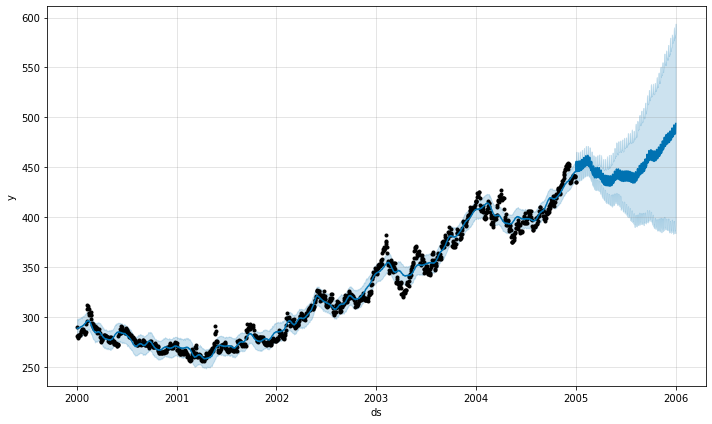

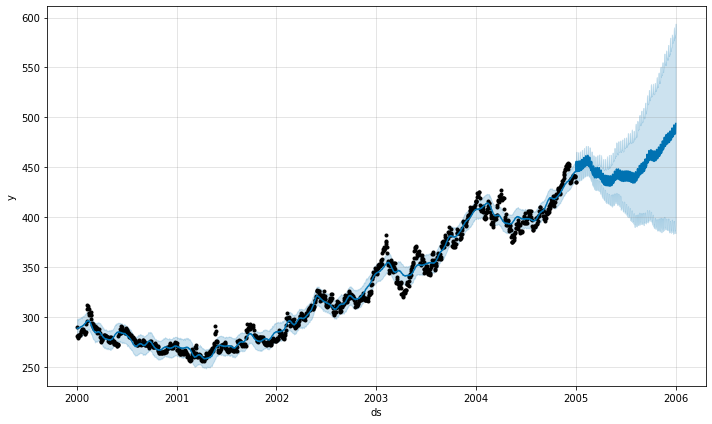

In [ ]:
df_future=model_proohet.make_future_dataframe(periods=365)
df_pred=model_proohet.predict(df_future)
model_proohet.plot(df_pred)

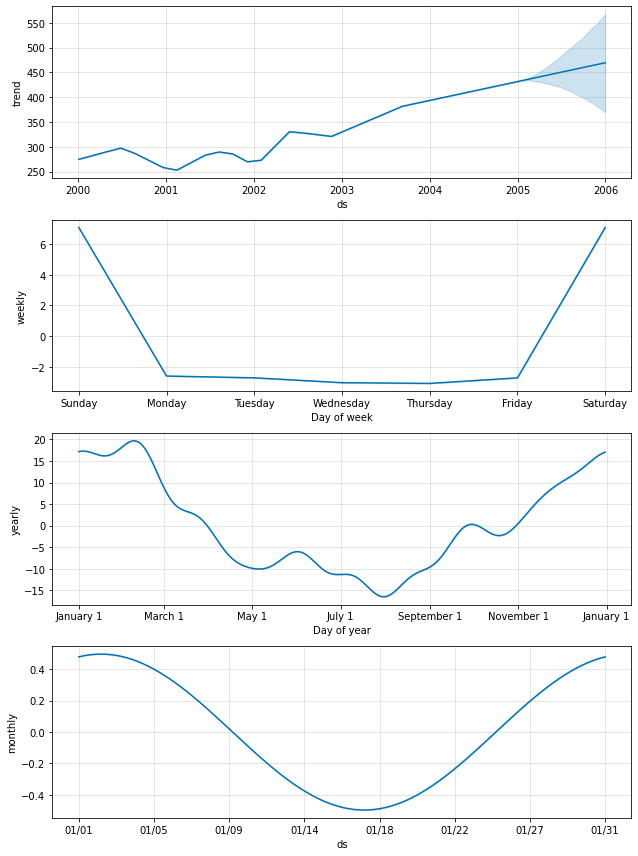

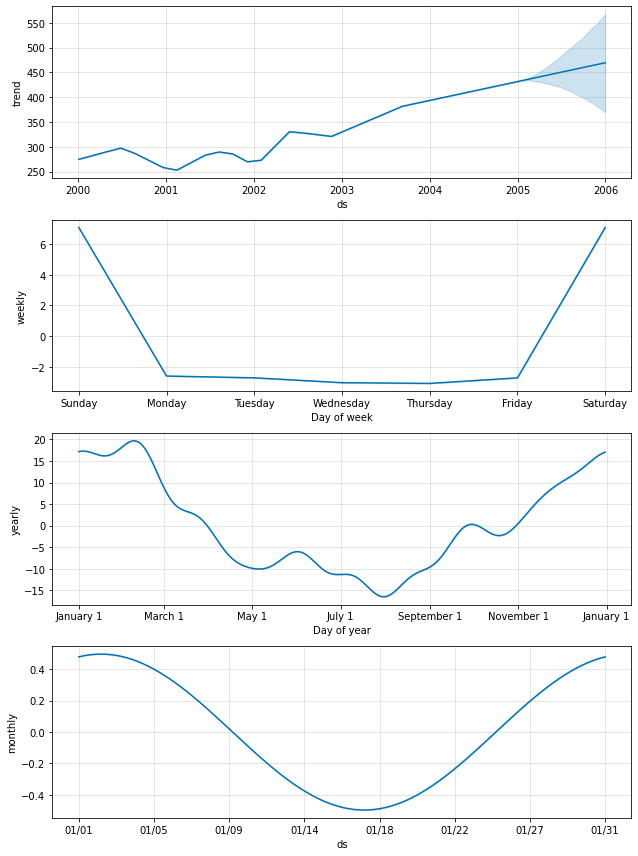

In [ ]:
model_proohet.plot_components(df_pred)

In [ ]:
selected_columns=['ds','yhat_lower','yhat_upper','yhat']

df_pred=df_pred.loc[:,selected_columns].reset_index(drop=True)
df_test=df_test.merge(df_pred,on=['ds'],how='left')
df_test.ds=pd.to_datetime(df_test.ds)
df_test.set_index('ds',inplace=True)

[Text(0, 0.5, 'Gold Price($)'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Gold Price')]

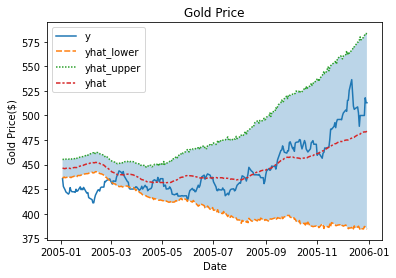

In [ ]:
fig,ax=plt.subplots(1,1)
ax=sns.lineplot(data=df_test[['y','yhat_lower','yhat_upper','yhat']])
ax.fill_between(df_test.index,df_test.yhat_lower,df_test.yhat_upper,alpha=0.3)
ax.set(title='Gold Price',xlabel='Date',ylabel='Gold Price($)')

# **Testing Stationary**


In [ ]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
#ADF test
def adf_test(x):
  ind=['Test Stat','pval','# of lags used','#of observation used']
  adf_test=adfuller(x,autolag='AIC')
  results=pd.Series(adf_test[0:4],index=ind)
  for key,value in adf_test[4].items():
    results[f'Critical Value({key})']=value


  return results

In [ ]:
df=quandl.get(dataset='WGC/GOLD_DAILY_USD',start_date='2000-01-01',end_date='2005-12-31')
df.head()

,Value
Date,
2000-01-03,290.25
2000-01-04,281.50
2000-01-05,280.45
2000-01-06,279.40
2000-01-07,282.10


In [ ]:
adf_test(df.Value)
#not stationary

Test Stat                  0.537432
pval                       0.985967
# of lags used             0.000000
#of observation used    1564.000000
Critical Value(1%)        -3.434538
Critical Value(5%)        -2.863390
Critical Value(10%)       -2.567755
dtype: float64

In [ ]:
def kpss_test(x,h0_type='c'):
    ind=['Test Stat','pval','# of lags']
    kpss_test=kpss(x,regression=h0_type)
    results=pd.Series(kpss_test[0:3],index=ind)
    for key,value in kpss_test[3].items():
        results[f'Critical Value({key})']=value

    return results

In [ ]:
kpss_test(df.Value)
#not stationary

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value



Test Stat                6.031672
pval                     0.010000
# of lags               24.000000
Critical Value(10%)      0.347000
Critical Value(5%)       0.463000
Critical Value(2.5%)     0.574000
Critical Value(1%)       0.739000
dtype: float64

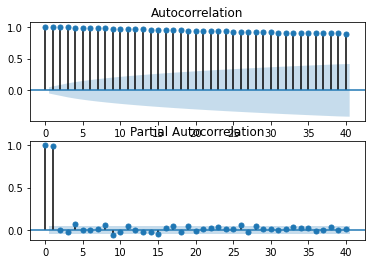

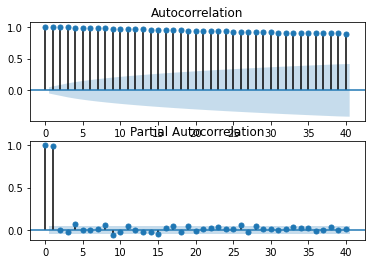

In [ ]:
N_lags=40
a=0.05
fig,ax=plt.subplots(2,1)
plot_acf(df.Value,ax=ax[0],lags=N_lags,alpha=a)
plot_pacf(df.Value,ax=ax[1],lags=N_lags,alpha=a)


In [ ]:
!pip install cpi


     |████████████████████████████████| 25.5 MB 29 kB/s 


# **make stationary**

In [ ]:
import cpi
from datetime import date


INFO:cpi:Parsing data files from the BLS
/usr/local/lib/python3.7/dist-packages/cpi/__init__.py:46: StaleDataWarning:

CPI data is out of date. To accurately inflate to today's dollars, you must run `cpi.update()`.



In [ ]:
def test_autocorrelation(x, n_lags=40, alpha=0.05, h0_type='c'):
    '''
    Function for testing the stationarity of a series by using:
    * the ADF test
    * the KPSS test
    * ACF/PACF plots
    Parameters
    ----------
    x: pd.Series / np.array
        The time series to be checked for stationarity
    n_lags : int
        The number of lags for the ACF/PACF plots
    alpha : float
        Significance level for the ACF/PACF plots
    h0_type: str{'c', 'ct'}
        Indicates the null hypothesis of the KPSS test:
            * 'c': The data is stationary around a constant(default)
            * 'ct': The data is stationary around a trend
    Returns
    -------
    fig : matplotlib.figure.Figure
        Figure containing the ACF/PACF plot
    '''

    adf_results = adf_test(x)
    kpss_results = kpss_test(x, h0_type=h0_type)

    print('ADF test statistic: {:.2f} (p-val: {:.2f})'.format(adf_results['Test Stat'],
                                                             adf_results['pval']))
    print('KPSS test statistic: {:.2f} (p-val: {:.2f})'.format(kpss_results['Test Stat'],
                                                              kpss_results['pval']))

    fig, ax = plt.subplots(2, figsize=(16, 8))
    plot_acf(x, ax=ax[0], lags=n_lags, alpha=alpha)
    plot_pacf(x, ax=ax[1], lags=n_lags, alpha=alpha)

    return fig

In [ ]:
cpi.update()

In [ ]:
import numpy as np

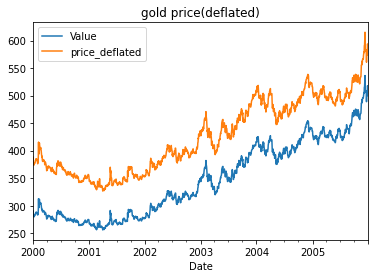

In [ ]:
defl_date=date(2011,12,31)
df['dt_index']=df.index.map(lambda x: x.to_pydatetime().date())
df['price_deflated']=df.apply(lambda x: cpi.inflate(x.Value,x.dt_index,defl_date),axis=1)
df[['Value','price_deflated']].plot(title='gold price(deflated)')

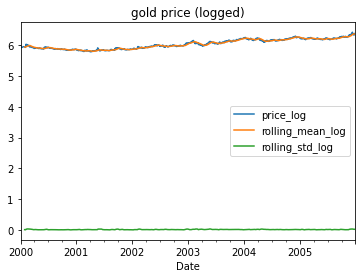

In [ ]:
win=20
df['price_log']=np.log(df.price_deflated)
df['rolling_mean_log']=df.price_log.rolling(window=win).mean()
df['rolling_std_log']=df.price_log.rolling(window=win).std()
df[['price_log','rolling_mean_log','rolling_std_log']].plot(title='gold price (logged)')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value



ADF test statistic: -0.09 (p-val: 0.95)
KPSS test statistic: 5.82 (p-val: 0.01)


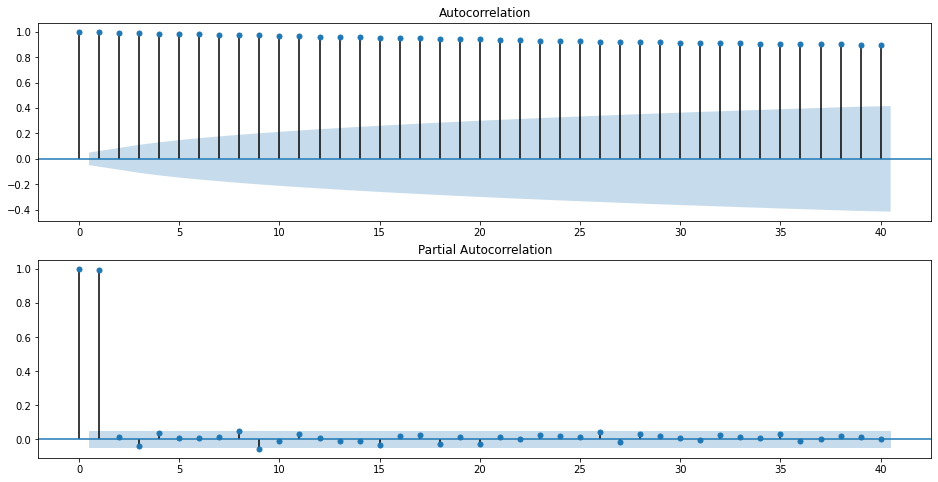

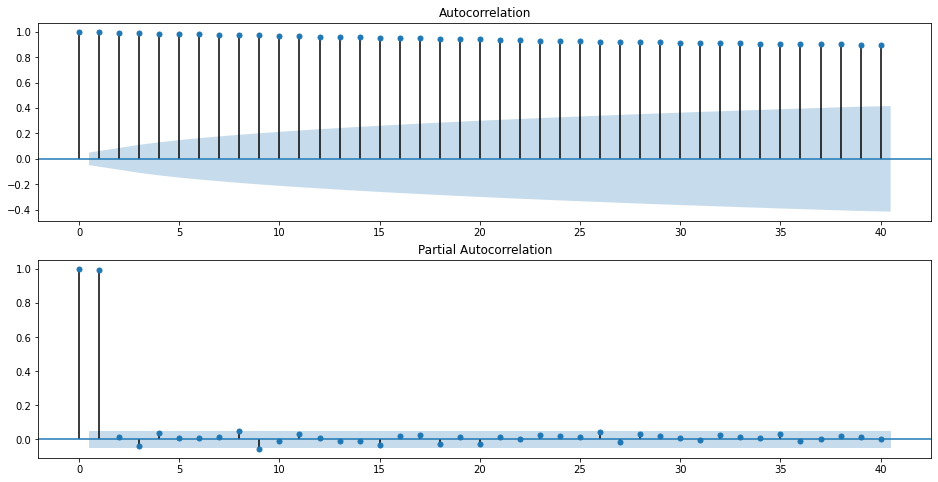

In [ ]:
test_autocorrelation(df.price_log)
#not enough to make stationary gold price

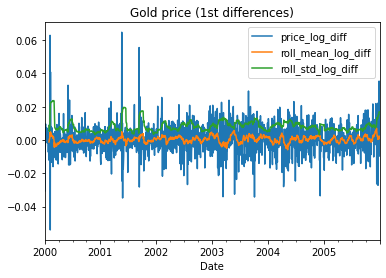

In [ ]:
df['price_log_diff']=df.price_log.diff(1)
df['roll_mean_log_diff']=df.price_log_diff.rolling(win).mean()
df['roll_std_log_diff']=df.price_log_diff.rolling(win).std()
df[['price_log_diff','roll_mean_log_diff','roll_std_log_diff']].plot(title='Gold price (1st differences)')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value



ADF test statistic: -41.56 (p-val: 0.00)
KPSS test statistic: 0.21 (p-val: 0.10)


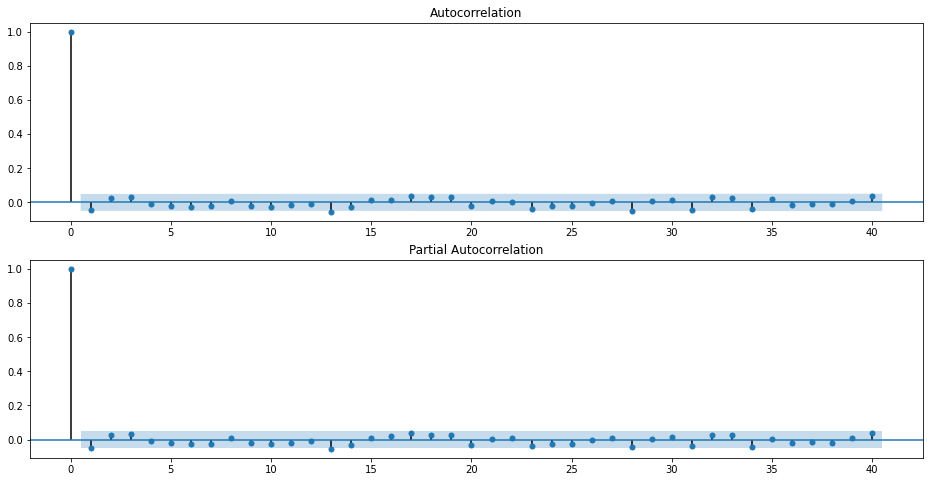

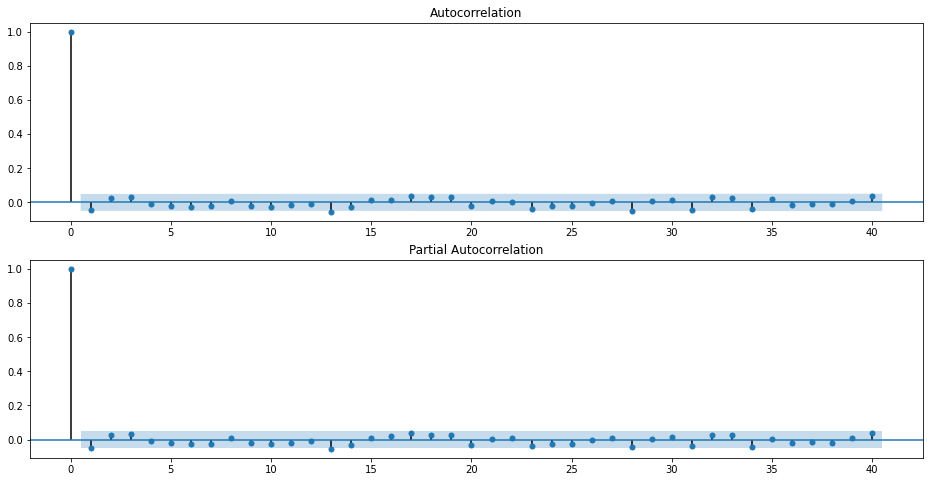

In [ ]:
test_autocorrelation(df.price_log_diff.dropna())